In [108]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, shapiro, spearmanr, kendalltau, jarque_bera
import statsmodels.api as sm
import pingouin as pg

## Reproduction of Determinants of apartment prices in Warsaw by Xinyue Fang

Study made by Xinyue is focused on explaining how different determinants are affecting house price on micro level. Research focuses on factors that influence the price of apartments in Warsaw, following hypothesis are formulated:
1. Influence of apartment type on it's price, it is assumed that tenement apartments should be the cheapest.
2. Non-linear relationship between size and price, it is expected for price to rise rapidly with the increase of flat size.
3. Positive relationship between floor and price - the higher the apartment is situated the higher the price. Lowest floor flats should be the cheapest.
4. Negative relationship between distance from city center and price.
5. Positive relationship between number of ammenities and price.
6. Ownership relationship between type of ownership an price.
7. Positive relationship between existance of elavator and price.
8. Positive rlationship between existance of balcony and price.


## Methods helpful in further steps ##

Method transform_data_from_file() for transforming data to the form used in paper, and aggregate_data() for creating new dataset from additional source files from kaggle.

In [70]:
def transform_data_from_file(file_path: str) -> pd.DataFrame:
    df_transformed = pd.read_csv(file_path)
    df_transformed = df_transformed[(df_transformed['city'] == 'warszawa')]
    df_transformed = df_transformed[
        ['id', 'city', 'type', 'squareMeters', 'floor', 'floorCount', 'centreDistance', 'poiCount', 'ownership',
         'hasBalcony', 'hasElevator', 'price']]
    df_transformed = df_transformed[
        (df_transformed['ownership'] == 'cooperative') | (df_transformed['ownership'] == 'condominium')]
    df_transformed = df_transformed[
        (df_transformed['type'] == 'apartmentBuilding') | (df_transformed['type'] == 'tenement') | (
                df_transformed['type'] == 'blockOfFlats')]
    df_transformed = df_transformed[
        (df_transformed['squareMeters'] > 0) | (df_transformed['floor'] >= 0) | (df_transformed['floorCount'] >= 0) | (
                df_transformed['poiCount'] >= 0) | (df_transformed['centreDistance'] >= 0) | (
                df_transformed['price'] >= 0)]

    df_transformed = df_transformed.dropna()
    df_transformed.drop_duplicates(subset='id', inplace=True)
    df_transformed.drop(axis='columns', labels=['city'], inplace=True)
    return df_transformed


def aggregate_data():
    df_list = []
    for file in os.listdir('data/source'):
        df = transform_data_from_file('data/source/' + file)
        df_list.append(df)
    aggregated_df = pd.concat(df_list, ignore_index=True)
    # Removing same offers across different months
    aggregated_df.drop_duplicates(subset='id', inplace=True)
    aggregated_df.drop(axis='columns', labels=['id'], inplace=True)
    return aggregated_df

Mappings along with methods for creating dummy variables

In [71]:
 mappings = {
        'type': {
            'tenement': 1,
            'blockOfFlats': 2,
            'apartmentBuilding': 3,
        },
        'ownership': {
            'condominium': 1,
            'cooperative': 0,
        },
        'hasBalcony': {
            'yes': 1,
            'no': 0
        },
        'hasElevator': {
            'yes': 1,
            'no': 0
        }
    }
def create_dummy_variables(df: pd.DataFrame) -> pd.DataFrame:
    df['floorType'] = df['floor'] / df['floorCount']

    # Step 2: Create floorTypeDummy using nested conditions
    df['floorType'] = np.where(
        df['floorType'] < 1 / 3, 1,
        np.where(df['floorType'] > 2 / 3, 3, 2)
    )

    df['poiCount'] = np.where(
        df['poiCount'] <= 30, 1, 2
    )

    for key, value in mappings.items():
        df[key] = df[key].map(value)

    df.drop(axis=1, columns=['floor', 'floorCount'], inplace=True)

    return df

Methods for plotting histograms and box plots:

In [72]:
def plot_historgram(df: pd.DataFrame, column: str, xlabel: str, title: str):
    x = df[column].dropna()
    plt.hist(x, bins=20, color='blue', density=True)
    xfit = np.linspace(x.min(), x.max(), 1000)
    yfit = norm.pdf(xfit, loc=x.mean(), scale=x.std())
    plt.plot(xfit, yfit, 'r', linewidth=2)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.title(title)

In [73]:
def plot_boxplot(df: pd.DataFrame, column: str):
    y = df[column].dropna()
    sns.boxplot(y)
    plt.title("Boxplot")
    plt.ylabel(column)
    plt.show()

## Handling Data ##

Original dataset was taken from https://www.kaggle.com/datasets/krzysztofjamroz/apartment-prices-in-poland . Originally research was done based on data from November 2023. Given the abilities of python which we are going to use, we decided to create two separate datasets - one just to reproduce the research and extend one with data since November 2023 up until June 2024. Source dataset from kaggle includes more variables than is required for research and rows for cities which are als not included, so we will need to do some adjusting of datasets.
Way to proceed:
1. Download data from aforementioned source and add csv files into source into data/source directory.
2. Recreate original dataset for November 2023 using transform_data_from_file() and create_dummy_variables() methods and drop id column.
3. Use methods aggregate aggregate_data() and create_dummy_variables() to generate extended dataset.

In [81]:
extended_df = create_dummy_variables(aggregate_data())
original_df = create_dummy_variables(transform_data_from_file('data/source/apartments_pl_2023_11.csv'))
original_df.drop(axis='columns', labels=['id'], inplace=True)

In [82]:
extended_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15805 entries, 0 to 27641
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            15805 non-null  int64  
 1   squareMeters    15805 non-null  float64
 2   centreDistance  15805 non-null  float64
 3   poiCount        15805 non-null  int32  
 4   ownership       15805 non-null  int64  
 5   hasBalcony      15805 non-null  int64  
 6   hasElevator     15805 non-null  int64  
 7   price           15805 non-null  int64  
 8   floorType       15805 non-null  int32  
dtypes: float64(2), int32(2), int64(5)
memory usage: 1.1 MB


In [83]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2899 entries, 10627 to 15415
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            2899 non-null   int64  
 1   squareMeters    2899 non-null   float64
 2   centreDistance  2899 non-null   float64
 3   poiCount        2899 non-null   int32  
 4   ownership       2899 non-null   int64  
 5   hasBalcony      2899 non-null   int64  
 6   hasElevator     2899 non-null   int64  
 7   price           2899 non-null   int64  
 8   floorType       2899 non-null   int32  
dtypes: float64(2), int32(2), int64(5)
memory usage: 203.8 KB


## Data description and visualization ##

Here we are focusing on recreating original research - visualizing data and checking if it's similar to what has been discovered previously. Additionally, for each variable we are running tests for extended dataset.

# Price - reproduction

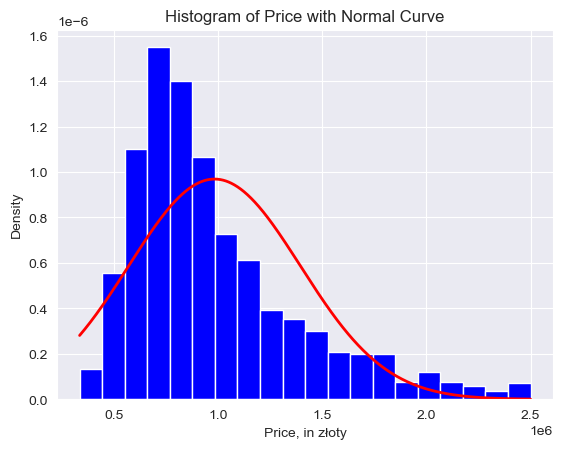

In [84]:
plot_historgram(original_df, 'price', 'Price, in złoty', 'Histogram of Price with Normal Curve')

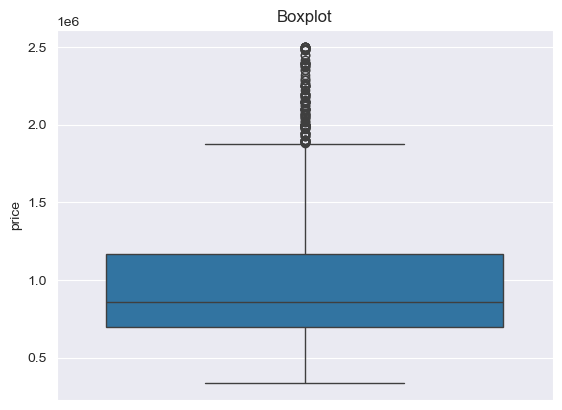

In [85]:
plot_boxplot(original_df, 'price')

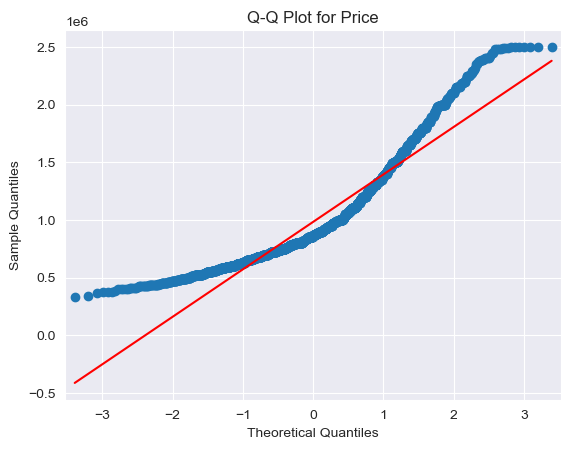

In [86]:
sm.qqplot(original_df['price'], line='s')
plt.title("Q-Q Plot for Price")
plt.show()

In [87]:
print("Jarque-Bera Test:")
print(jarque_bera(original_df['price']))

print("\nShapiro-Wilk Test:")
print(shapiro(original_df['price']))

Jarque-Bera Test:
SignificanceResult(statistic=1099.7331633131287, pvalue=1.5702825463754407e-239)

Shapiro-Wilk Test:
ShapiroResult(statistic=0.8869559221929003, pvalue=8.544425137369543e-42)


We performed the sama tests, and we can reject the null hypothesis that the density distribution is normal as in the original research.

# Price - extended (tests only)

In [88]:
print("Jarque-Bera Test:")
print(jarque_bera(extended_df['price']))

print("\nShapiro-Wilk Test:")
print(shapiro(extended_df['price']))

Jarque-Bera Test:
SignificanceResult(statistic=17626.185129476005, pvalue=0.0)

Shapiro-Wilk Test:
ShapiroResult(statistic=0.8298882087070528, pvalue=1.9971654181950534e-83)


C:\Users\bdbar\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15805.
  res = hypotest_fun_out(*samples, **kwds)


 P-values are even smaller than for original dataset, thus confirming that density distribution is not normal.

# Square Meters - reproduction

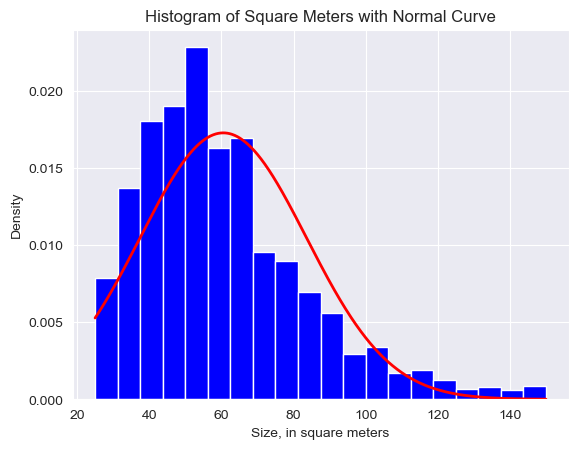

In [89]:
plot_historgram(original_df, 'squareMeters', 'Size, in square meters', 'Histogram of Square Meters with Normal Curve')

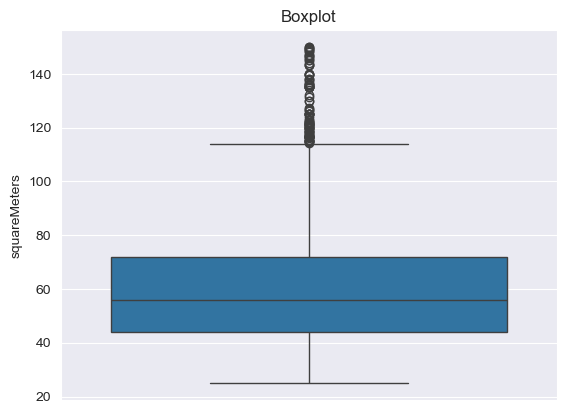

In [90]:
plot_boxplot(original_df, 'squareMeters')

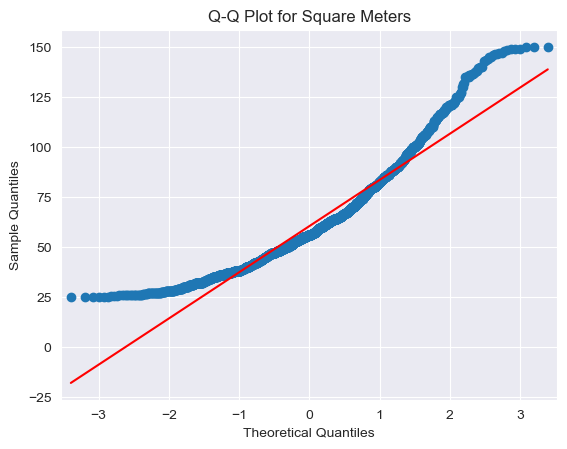

In [91]:
sm.qqplot(original_df['squareMeters'], line='s')
plt.title("Q-Q Plot for Square Meters")
plt.show()

In [92]:
print("Jarque-Bera Test:")
print(jarque_bera(original_df['squareMeters']))

print("\nShapiro-Wilk Test:")
print(shapiro(original_df['squareMeters']))

Jarque-Bera Test:
SignificanceResult(statistic=833.0745598381227, pvalue=1.2593829929107486e-181)

Shapiro-Wilk Test:
ShapiroResult(statistic=0.9268601813985676, pvalue=1.8708421286606493e-35)


As in original research we can reject null hypothesis that density distribution is normal.

# Square Meters - extended (tests only)

In [93]:
print("Jarque-Bera Test:")
print(jarque_bera(extended_df['squareMeters']))

print("\nShapiro-Wilk Test:")
print(shapiro(extended_df['squareMeters']))

Jarque-Bera Test:
SignificanceResult(statistic=6895.547279201677, pvalue=0.0)

Shapiro-Wilk Test:
ShapiroResult(statistic=0.9109761386417455, pvalue=2.431741203994343e-69)


C:\Users\bdbar\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15805.
  res = hypotest_fun_out(*samples, **kwds)


We can observe that as for previous variable, p-values are even smaller than originally. Rejection is sustained.

# Distance from city centre - reproduction

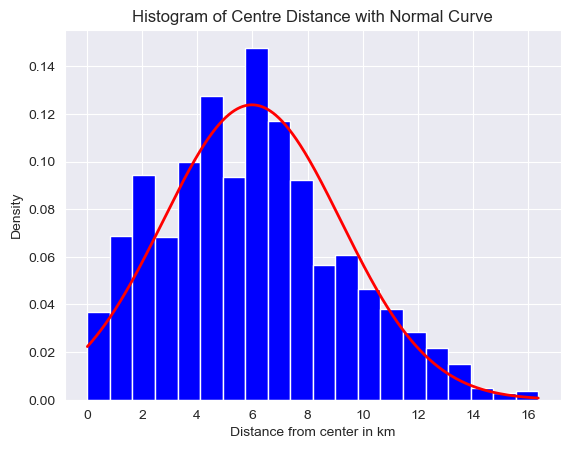

In [94]:
plot_historgram(original_df, 'centreDistance', 'Distance from center in km',
                'Histogram of Centre Distance with Normal Curve')

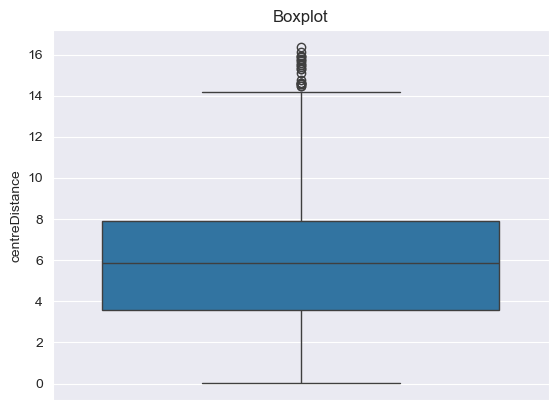

In [95]:
plot_boxplot(original_df, 'centreDistance')

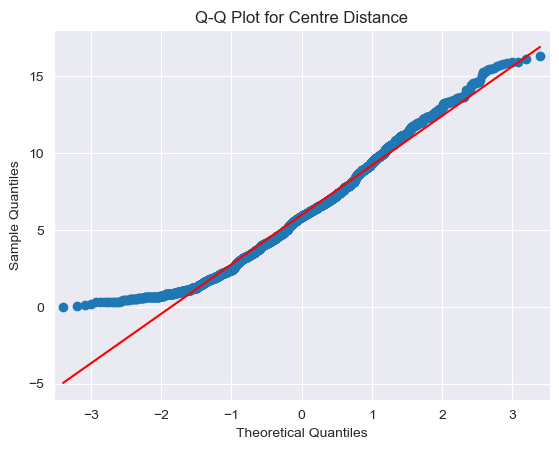

In [96]:
sm.qqplot(original_df['centreDistance'], line='s')
plt.title("Q-Q Plot for Centre Distance")
plt.show()

In [97]:
print("Jarque-Bera Test:")
print(jarque_bera(original_df['centreDistance']))

print("\nShapiro-Wilk Test:")
print(shapiro(original_df['centreDistance']))

Jarque-Bera Test:
SignificanceResult(statistic=97.26848710196971, pvalue=7.558165446104713e-22)

Shapiro-Wilk Test:
ShapiroResult(statistic=0.9790141903390822, pvalue=2.7654046886374875e-20)


Again as in original research we can reject null hypothesis that density distribution is normal.


# Distance to city centre - extend (tests only)

In [98]:
print("Jarque-Bera Test:")
print(jarque_bera(extended_df['centreDistance']))

print("\nShapiro-Wilk Test:")
print(shapiro(extended_df['centreDistance']))

Jarque-Bera Test:
SignificanceResult(statistic=474.98701167496404, pvalue=7.209097959991088e-104)

Shapiro-Wilk Test:
ShapiroResult(statistic=0.9821044933533869, pvalue=3.5421787070195214e-40)


C:\Users\bdbar\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15805.
  res = hypotest_fun_out(*samples, **kwds)


We can reject null hypothesis that density distribution is normal.

Correlation - Price vs squareMeters

In [99]:
# Spearman correlation: price vs squareMeters
print("Spearman Correlation: Price vs Square Meters")
print(spearmanr(original_df['price'], original_df['squareMeters']))

# Kendall correlation: price vs centreDistance
print("Kendall Correlation: Price vs Centre Distance")
print(kendalltau(original_df['price'], original_df['squareMeters']))

Spearman Correlation: Price vs Square Meters
SignificanceResult(statistic=0.7767851763674094, pvalue=0.0)
Kendall Correlation: Price vs Centre Distance
SignificanceResult(statistic=0.5831896336337636, pvalue=0.0)


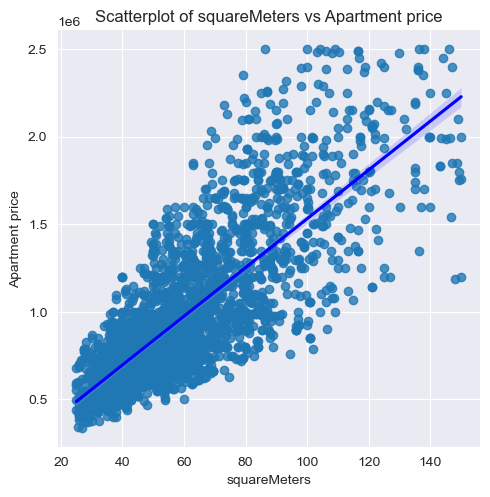

In [100]:
sns.lmplot(x='squareMeters', y='price', data=original_df, line_kws={"color": "blue"})
plt.title("Scatterplot of squareMeters vs Apartment price")
plt.xlabel("squareMeters")
plt.ylabel("Apartment price")
plt.show()

Correlation - price vs distance from city center

In [101]:
# Spearman correlation: price vs centreDistance
print("\nSpearman Correlation: Price vs Centre Distance")
print(spearmanr(original_df['price'], original_df['centreDistance']))

# Kendall correlation: price vs centreDistance
print("Kendall Correlation: Price vs Centre Distance")
print(kendalltau(original_df['price'], original_df['centreDistance']))


Spearman Correlation: Price vs Centre Distance
SignificanceResult(statistic=-0.16166033247982134, pvalue=1.9859449326510368e-18)
Kendall Correlation: Price vs Centre Distance
SignificanceResult(statistic=-0.10724289857088193, pvalue=5.824176937802178e-18)


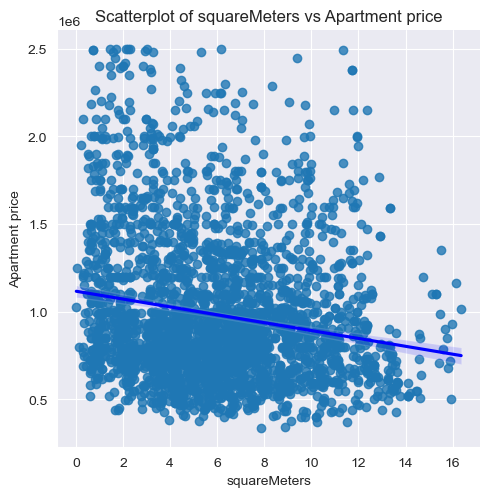

In [102]:
sns.lmplot(x='centreDistance', y='price', data=original_df, line_kws={"color": "blue"})
plt.title("Scatterplot of squareMeters vs Apartment price")
plt.xlabel("squareMeters")
plt.ylabel("Apartment price")
plt.show()

# Dummy Variables - reproduction

Price Summary by Type{'tenement': 1, 'blockOfFlats': 2, 'apartmentBuilding': 3}:
       count          mean            std       min       25%        50%  \
type                                                                       
1      403.0  1.144024e+06  501714.073616  405000.0  779500.0   990000.0   
2     1650.0  8.478287e+05  304632.278366  335000.0  654250.0   778775.0   
3      846.0  1.169317e+06  444566.019892  340800.0  831699.0  1080000.0   

            75%        max  
type                        
1     1449500.0  2500000.0  
2      950000.0  2500000.0  
3     1450000.0  2500000.0  


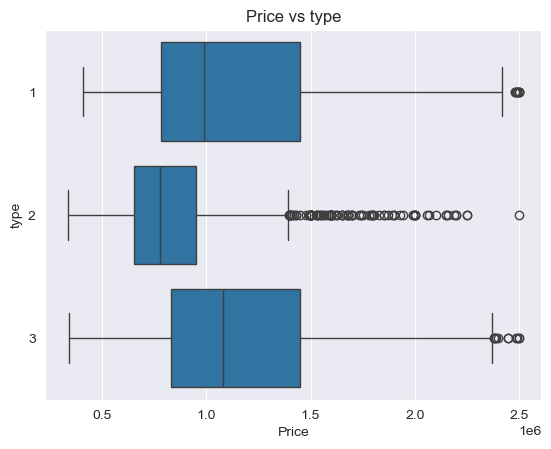

Price Summary by FloortypeNone:
            count          mean            std       min       25%       50%  \
floorType                                                                      
1           617.0  9.512598e+05  397796.674156  399000.0  680136.0  815000.0   
2          1067.0  1.008304e+06  403924.240051  340800.0  725000.0  899000.0   
3          1215.0  9.764720e+05  424178.471225  335000.0  679613.0  864000.0   

                 75%        max  
floorType                        
1          1149305.0  2500000.0  
2          1204500.0  2500000.0  
3          1142400.0  2500000.0  


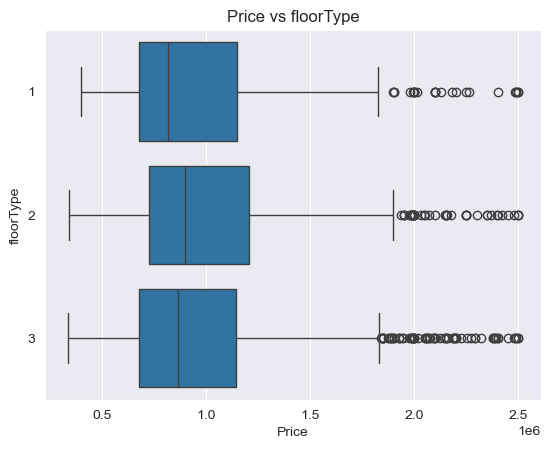

Price Summary by Ownership{'condominium': 1, 'cooperative': 0}:
            count          mean            std       min       25%       50%  \
ownership                                                                      
0           398.0  8.462069e+05  335035.524708  375000.0  650000.0  759500.0   
1          2501.0  1.004562e+06  418576.387306  335000.0  702000.0  890000.0   

                 75%        max  
ownership                        
0           918750.0  2380000.0  
1          1200000.0  2500000.0  


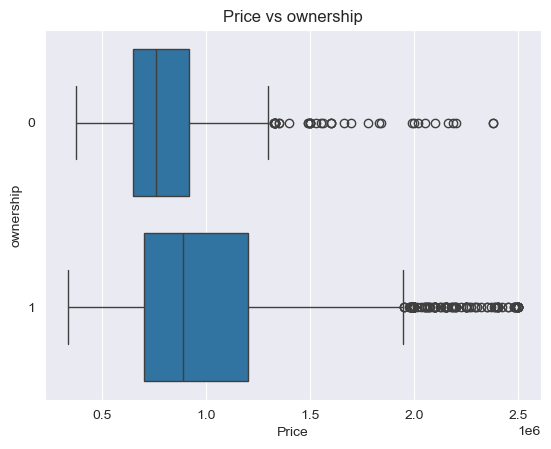

Price Summary by PoicountNone:
           count          mean            std       min       25%       50%  \
poiCount                                                                      
1         2283.0  9.436042e+05  382711.184714  335000.0  680000.0  840000.0   
2          616.0  1.128170e+06  477840.580290  375000.0  769975.0  983290.0   

                75%        max  
poiCount                        
1         1100000.0  2499999.0  
2         1406250.0  2500000.0  


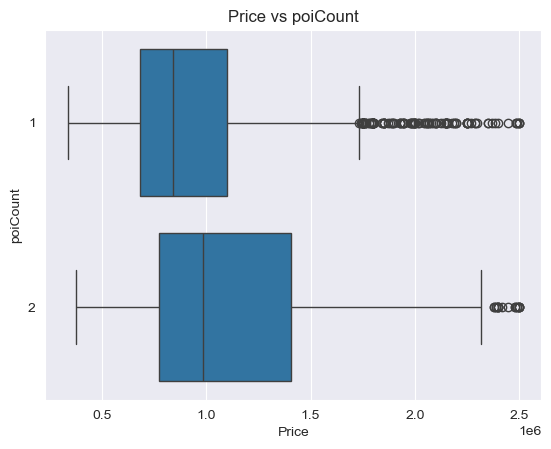

Price Summary by Hasbalcony{'yes': 1, 'no': 0}:
             count          mean            std       min        25%  \
hasBalcony                                                             
0            928.0  9.381483e+05  401818.976783  335000.0  659356.25   
1           1971.0  1.003856e+06  414699.712515  340800.0  719999.00   

                 50%        75%        max  
hasBalcony                                  
0           820000.0  1100000.0  2485350.0  
1           880000.0  1200000.0  2500000.0  


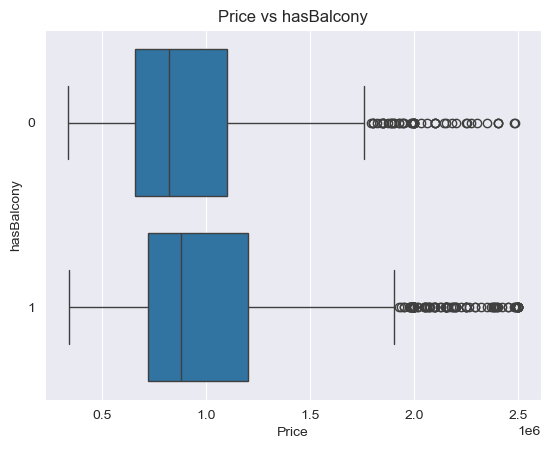

Price Summary by Haselevator{'yes': 1, 'no': 0}:
              count           mean            std       min       25%  \
hasElevator                                                             
0             835.0  949134.201198  401777.155288  335000.0  680000.0   
1            2064.0  996450.557171  414958.526588  340800.0  700000.0   

                  50%        75%        max  
hasElevator                                  
0            830000.0  1099500.0  2500000.0  
1            880000.0  1199000.0  2500000.0  


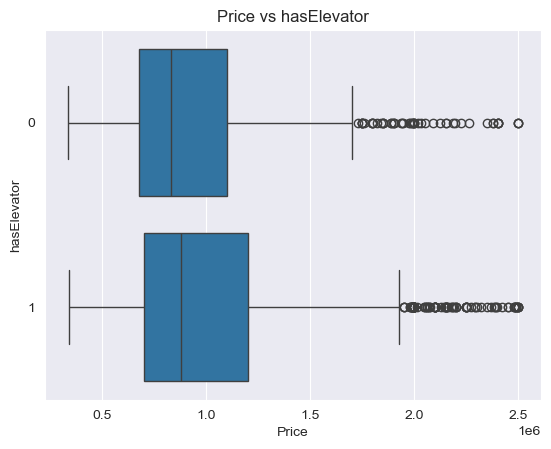

In [104]:
dummy_variables = ['type', 'floorType', 'ownership', 'poiCount', 'hasBalcony', 'hasElevator']


def table(df: pd.DataFrame):
    for dummy in dummy_variables:
        print(f"Price Summary by {dummy.title()}{mappings.get(dummy)}:")
        print(df.groupby(dummy)['price'].describe())
        sns.boxplot(y=dummy, x='price', data=df, orient='h')
        plt.title(f"Price vs {dummy}")
        plt.xlabel("Price")
        plt.ylabel(dummy)
        plt.show()


table(original_df)

In [105]:
datacorr = original_df[["price", "squareMeters", "type", "floorType",
                      "centreDistance", "poiCount", "ownership",
                      "hasBalcony", "hasElevator"]]

cor_matrix = datacorr.corr(numeric_only=True)
print(cor_matrix)

                   price  squareMeters      type  floorType  centreDistance  \
price           1.000000      0.779972  0.121840   0.012835       -0.175756   
squareMeters    0.779972      1.000000  0.111468   0.061308        0.134817   
type            0.121840      0.111468  1.000000  -0.073471        0.260340   
floorType       0.012835      0.061308 -0.073471   1.000000        0.059355   
centreDistance -0.175756      0.134817  0.260340   0.059355        1.000000   
poiCount        0.183419     -0.001750 -0.223422  -0.006664       -0.496440   
ownership       0.132399      0.019370  0.086075  -0.018149        0.021791   
hasBalcony      0.074470      0.128611  0.172367  -0.027520        0.175493   
hasElevator     0.052055     -0.077369  0.387338  -0.162481       -0.009041   

                poiCount  ownership  hasBalcony  hasElevator  
price           0.183419   0.132399    0.074470     0.052055  
squareMeters   -0.001750   0.019370    0.128611    -0.077369  
type           -0.22

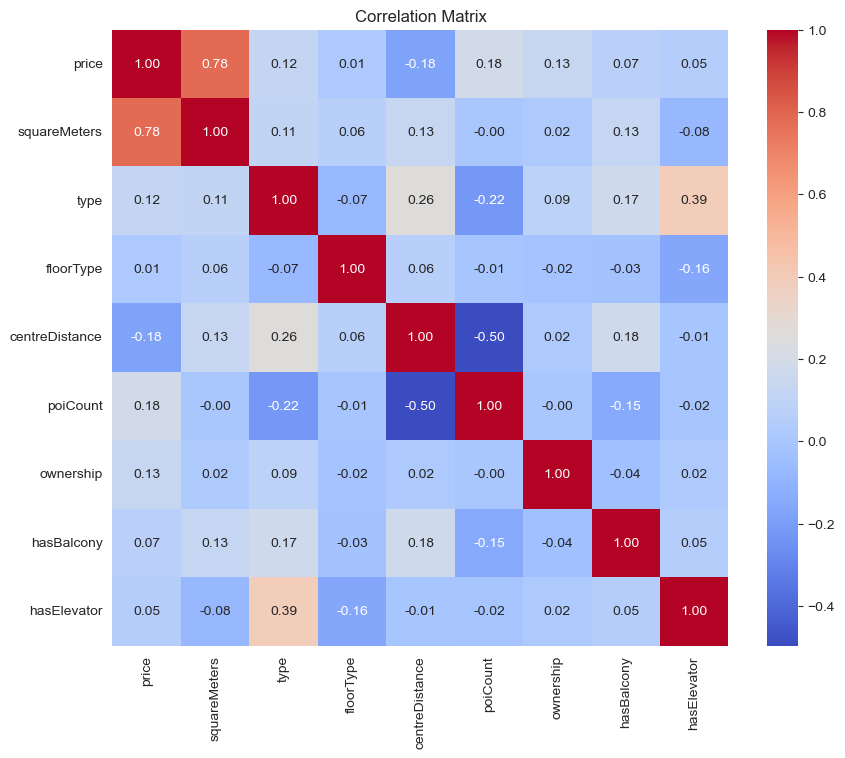

Significant Correlations with 'price' (p < 0.05):
       X               Y         r         p-unc
0  price    squareMeters  0.779972  0.000000e+00
4  price        poiCount  0.183419  2.372908e-23
3  price  centreDistance -0.175756  1.523370e-21
5  price       ownership  0.132399  8.239653e-13
1  price            type  0.121840  4.646358e-11
6  price      hasBalcony  0.074470  5.982477e-05
7  price     hasElevator  0.052055  5.055940e-03


In [110]:
# Correlation matrix with values
plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()

# With significance levels (p-values)
results = pg.pairwise_corr(datacorr, method='pearson')
sig_corrs = results[results['p-unc'] < 0.05]

# Filter to only rows where 'price' is one of the variables
price_corrs = sig_corrs[(sig_corrs['X'] == 'price') | (sig_corrs['Y'] == 'price')]

# Optional: sort by absolute correlation strength
price_corrs = price_corrs.copy()
price_corrs['abs_r'] = price_corrs['r'].abs()
price_corrs = price_corrs.sort_values('abs_r', ascending=False)

# Display cleaned result
print("Significant Correlations with 'price' (p < 0.05):")
print(price_corrs[['X', 'Y', 'r', 'p-unc']])